In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import h3
import folium

# 

In [2]:
order = pd.read_csv("./datasets/data_orders.csv")
offer = pd.read_csv("./datasets/data_offers.csv")

order.head()

,order_datetime,origin_longitude,origin_latitude,m_order_eta,order_gk,order_status_key,is_driver_assigned_key,cancellations_time_in_seconds
0,18:08:07,-0.978916,51.456173,60.0,3000583041974,4,1,198.0
1,20:57:32,-0.950385,51.456843,NaN,3000583116437,4,0,128.0
2,12:07:50,-0.969520,51.455544,477.0,3000582891479,4,1,46.0
3,13:50:20,-1.054671,51.460544,658.0,3000582941169,4,1,62.0
4,21:24:45,-0.967605,51.458236,NaN,3000583140877,9,0,NaN


In [3]:
offer.head()

,order_gk,offer_id
0,3000579625629,300050936206
1,3000627306450,300052064651
2,3000632920686,300052408812
3,3000632771725,300052393030
4,3000583467642,300051001196


In [4]:
order['order_status_key'] = order['order_status_key'].astype(str)

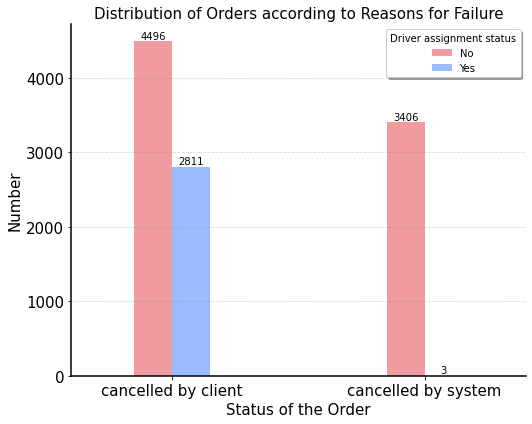

In [5]:
blue = (155/255, 187/255, 255/255)
red = (240/255, 155/255, 160/255)

fig, ax = plt.subplots(1, 1, figsize=(7.5, 6))

cross_tab = pd.crosstab(order['order_status_key'],
                        order['is_driver_assigned_key'])
cross_tab.plot(kind='bar', ax=ax, color=[red, blue], width=0.3)

ax.legend(fontsize=10, title='Driver assignment status',
          title_fontsize=10, fancybox=True, shadow=True, labels=['No', 'Yes'])

ax.set_xticklabels(
    ['cancelled by client', 'cancelled by system'], rotation=0, fontsize=15)
ax.tick_params(axis='y', labelsize=15)

ax.set_xlabel("Status of the Order", fontsize=15)
ax.set_ylabel("Number", fontsize=15)

for i in ax.patches:
    ax.annotate(str(i.get_height()), (i.get_x() + i.get_width() / 2,
                i.get_height()), ha='center', va='bottom', fontsize=10)

ax.set_title(
    'Distribution of Orders according to Reasons for Failure', fontsize=15)

plt.tight_layout()

ax.yaxis.grid(True, linestyle='--', which='major', color='grey', alpha=.3)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.spines['left'].set_linewidth(1.5)
ax.spines['bottom'].set_linewidth(1.5)
plt.savefig('1.jpg', dpi=300)

# 

In [6]:
order['order_datetime'] = pd.to_datetime(order['order_datetime'])
order['hour'] = order['order_datetime'].dt.hour
hour = order['order_datetime'].dt.hour.value_counts()

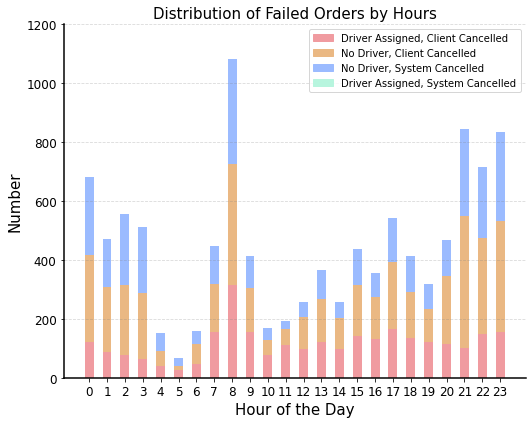

In [7]:
yellow = (234/255, 184/255, 131/255)
green = (183/255, 245/255, 222/255)
fig, ax = plt.subplots(1, 1, figsize=(7.5, 6))
for i in range(24):
    onefour = order[(order['hour'] == i) & (
        order['is_driver_assigned_key'] == 1) & (order['order_status_key'] == '4')]
    zerofour = order[(order['hour'] == i) & (
        order['is_driver_assigned_key'] == 0) & (order['order_status_key'] == '4')]
    onenine = order[(order['hour'] == i) & (
        order['is_driver_assigned_key'] == 1) & (order['order_status_key'] == '9')]
    zeronine = order[(order['hour'] == i) & (
        order['is_driver_assigned_key'] == 0) & (order['order_status_key'] == '9')]
    ax.bar(i, len(onefour), color=red, width=0.5)
    ax.bar(i, len(zerofour), color=yellow, width=0.5, bottom=len(onefour))
    ax.bar(i, len(zeronine), color=blue, width=0.5,
           bottom=len(onefour)+len(zerofour))
    ax.bar(i, len(onenine), color=green, width=0.5,
           bottom=len(onefour)+len(zerofour)+len(zeronine))

ax.set_xticks(range(0, 24))
ax.set_ylim([0, 1200])
ax.set_xticklabels(labels=[str(i) for i in range(
    0, 24)], rotation=0, fontsize=12)

ax.tick_params(axis='y', labelsize=12)

ax.set_xlabel("Hour of the Day", fontsize=15)
ax.set_ylabel("Number", fontsize=15)
ax.set_title("Distribution of Failed Orders by Hours", fontsize=15)

legend_labels = ['Driver Assigned, Client Cancelled', 'No Driver, Client Cancelled',
                 'No Driver, System Cancelled', 'Driver Assigned, System Cancelled']
legend_patches = [
    mpatches.Patch(color=red, label=legend_labels[0]),
    mpatches.Patch(color=yellow, label=legend_labels[1]),
    mpatches.Patch(color=blue, label=legend_labels[2]),
    mpatches.Patch(color=green, label=legend_labels[3])
]
ax.legend(handles=legend_patches, title_fontsize=12)

plt.tight_layout()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.spines['left'].set_linewidth(1.5)
ax.spines['bottom'].set_linewidth(1.5)
ax.yaxis.grid(True, linestyle='--', which='major', color='grey', alpha=.3)

plt.savefig('2.jpg', dpi=300)

# 


In [8]:
have_driver = order[order['is_driver_assigned_key'] == 1]
no_driver = order[order['is_driver_assigned_key'] == 0]
cancel_have = have_driver.groupby(
    'hour')["cancellations_time_in_seconds"].mean()
cancel_no = no_driver.groupby('hour')["cancellations_time_in_seconds"].mean()

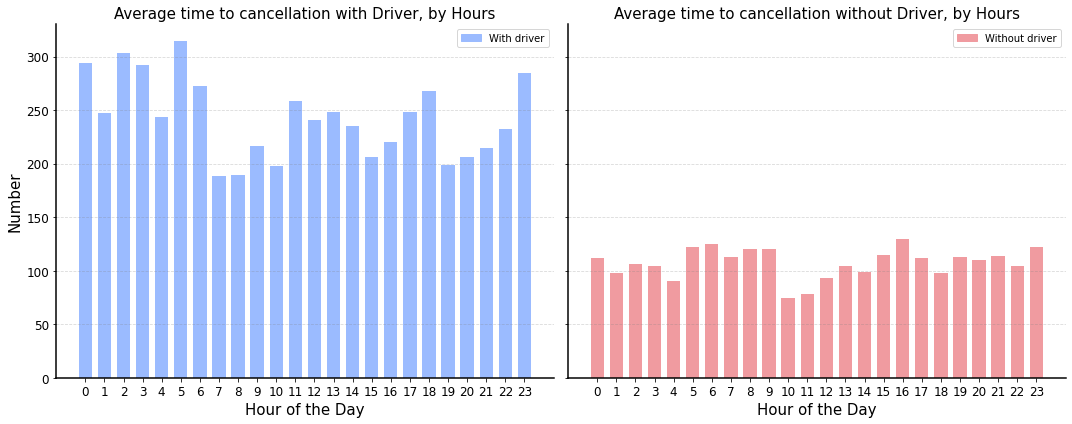

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(15, 6), sharey=True)
ax[0].bar(cancel_have.index, cancel_have.values, color=blue, width=0.7)
ax[0].set_xticks(range(0, 24))  # 设置刻度位置
ax[0].set_xticklabels(labels=[str(i) for i in range(
    0, 24)], rotation=0, fontsize=12)  # 设置刻度标签

ax[0].tick_params(axis='y', labelsize=12)

ax[0].set_xlabel("Hour of the Day", fontsize=15)
ax[0].set_ylabel("Number", fontsize=15)
ax[0].set_title(
    "Average time to cancellation with Driver, by Hours", fontsize=15)

ax[1].bar(cancel_no.index, cancel_no.values, color=red, width=0.7)
ax[1].set_xticks(range(0, 24))  # 设置刻度位置
ax[1].set_xticklabels(labels=[str(i) for i in range(
    0, 24)], rotation=0, fontsize=12)  # 设置刻度标签

ax[1].tick_params(axis='y', labelsize=12)

ax[1].set_xlabel("Hour of the Day", fontsize=15)
ax[1].set_title(
    "Average time to cancellation without Driver, by Hours", fontsize=15)

plt.tight_layout()
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)

ax[0].spines['left'].set_linewidth(1.5)
ax[0].spines['bottom'].set_linewidth(1.5)

ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)

ax[1].spines['left'].set_linewidth(1.5)
ax[1].spines['bottom'].set_linewidth(1.5)

legend_patches = [
    mpatches.Patch(color=blue, label="With driver"),
]
ax[0].legend(handles=legend_patches, title_fontsize=15)
legend_patches = [
    mpatches.Patch(color=red, label="Without driver"),
]
ax[1].legend(handles=legend_patches, title_fontsize=15)

ax[0].yaxis.grid(True, linestyle='--', which='major', color='grey', alpha=.3)
ax[1].yaxis.grid(True, linestyle='--', which='major', color='grey', alpha=.3)
plt.savefig('3.1.jpg', dpi=300)

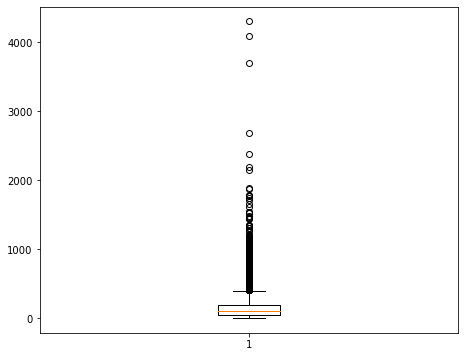

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(7.5, 6))
ax.boxplot(order['cancellations_time_in_seconds'].dropna())
plt.savefig('3.2.jpg', dpi=300)

In [11]:
data = order['cancellations_time_in_seconds'].dropna()
Q1 = np.percentile(data, 25)
Q3 = np.percentile(data, 75)
IQR = Q3 - Q1
upper_limit = Q3 + 1.5 * IQR
lower_limit = Q1 - 1.5 * IQR

cleaned_order = order[(order["cancellations_time_in_seconds"] >= lower_limit) & (
    order["cancellations_time_in_seconds"] <= upper_limit)]

In [12]:
have_driver_cleaned = cleaned_order[cleaned_order['is_driver_assigned_key'] == 1]
no_driver_cleaned = cleaned_order[cleaned_order['is_driver_assigned_key'] == 0]
cancel_have_cleaned = have_driver_cleaned.groupby(
    'hour')["cancellations_time_in_seconds"].mean()
cancel_no_cleaned = no_driver_cleaned.groupby(
    'hour')["cancellations_time_in_seconds"].mean()

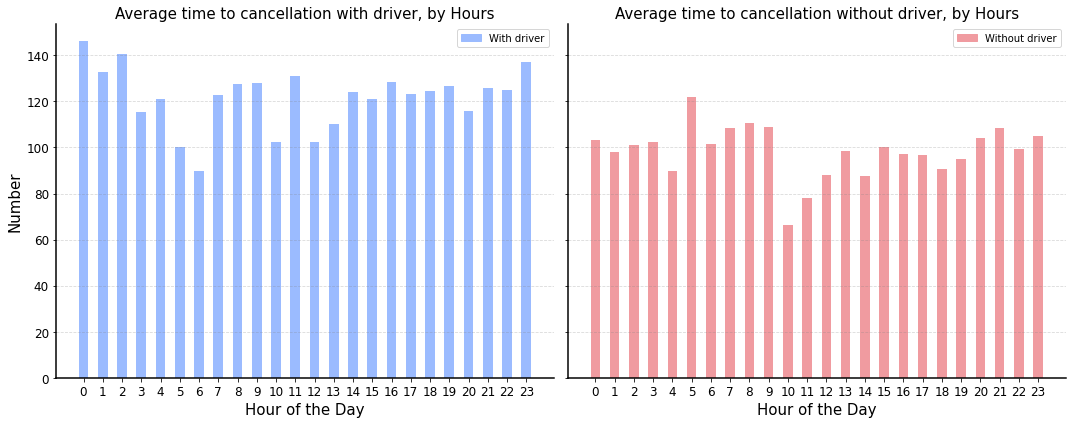

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(15, 6), sharey=True)
ax[0].bar(cancel_have_cleaned.index,
          cancel_have_cleaned.values, color=blue, width=0.5)
ax[0].set_xticks(range(0, 24))
ax[0].set_xticklabels(labels=[str(i) for i in range(
    0, 24)], rotation=0, fontsize=12)

ax[0].tick_params(axis='y', labelsize=12)

ax[0].set_xlabel("Hour of the Day", fontsize=15)
ax[0].set_ylabel("Number", fontsize=15)
ax[0].set_title(
    "Average time to cancellation with driver, by Hours", fontsize=15)

ax[1].bar(cancel_no_cleaned.index,
          cancel_no_cleaned.values, color=red, width=0.5)
ax[1].set_xticks(range(0, 24))
ax[1].set_xticklabels(labels=[str(i) for i in range(
    0, 24)], rotation=0, fontsize=12)

ax[1].tick_params(axis='y', labelsize=12)

ax[1].set_xlabel("Hour of the Day", fontsize=15)
ax[1].set_title(
    "Average time to cancellation without driver, by Hours", fontsize=15)

plt.tight_layout()
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)

ax[0].spines['left'].set_linewidth(1.5)
ax[0].spines['bottom'].set_linewidth(1.5)

ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)

ax[1].spines['left'].set_linewidth(1.5)
ax[1].spines['bottom'].set_linewidth(1.5)

legend_patches = [
    mpatches.Patch(color=blue, label="With driver"),
]
ax[0].legend(handles=legend_patches, title_fontsize=15)
legend_patches = [
    mpatches.Patch(color=red, label="Without driver"),
]
ax[1].legend(handles=legend_patches, title_fontsize=15)

ax[0].yaxis.grid(True, linestyle='--', which='major', color='grey', alpha=.3)
ax[1].yaxis.grid(True, linestyle='--', which='major', color='grey', alpha=.3)
plt.savefig('3.3.jpg', dpi=300)

# 

In [14]:
eta = order.groupby('hour')["m_order_eta"].mean()

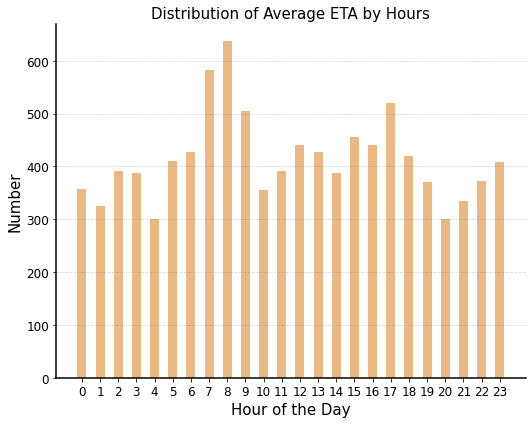

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(7.5, 6))
ax.bar(eta.index, eta.values, color=yellow, width=0.5)
ax.set_xticks(range(0, 24))
ax.set_xticklabels(labels=[str(i) for i in range(
    0, 24)], rotation=0, fontsize=12)

ax.tick_params(axis='y', labelsize=12)

ax.set_xlabel("Hour of the Day", fontsize=15)
ax.set_ylabel("Number", fontsize=15)
ax.set_title("Distribution of Average ETA by Hours", fontsize=15)
plt.tight_layout()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.spines['left'].set_linewidth(1.5)
ax.spines['bottom'].set_linewidth(1.5)
ax.yaxis.grid(True, linestyle='--', which='major', color='grey', alpha=.3)
plt.savefig('4.jpg', dpi=300)

# 

In [16]:
order['h3_cell'] = order.apply(lambda row: h3.geo_to_h3(
    row['origin_latitude'], row['origin_longitude'], 8), axis=1)

hex_counts = order['h3_cell'].value_counts()
total_orders = hex_counts.sum()

hex_counts_cumulative = hex_counts.cumsum() / total_orders

target_hexagons = hex_counts_cumulative[hex_counts_cumulative <= 0.809].index

m = folium.Map(location=[order['origin_latitude'].mean(),
               order['origin_longitude'].mean()], zoom_start=12)

for hex_cell, count in hex_counts.items():
    if hex_cell in target_hexagons:
        lat_lngs = h3.h3_to_geo_boundary(hex_cell)
        normalized_count = count / total_orders 
        fill_opacity = np.sqrt(normalized_count)
        folium.Polygon(lat_lngs, fill=True, fill_color='red',
                       fill_opacity=fill_opacity, color='darkblue').add_to(m)

m.save('map.html')
m